In [1]:
import os
import sys
sys.path.append("..")

In [23]:
aveta_data_path = "/home/ubuntu/aveta-data-master/generated/"
#aveta_data_path = os.path.expanduser("~/aveta-data-sample")

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread, imsave, imresize
%matplotlib inline

In [25]:
def read_speedfile(path=None):
    if path is None:
        path = aveta_data_path
    speedfile = os.path.join(path, "speeds.txt")
    ret = {}
    with open(speedfile) as fp:
        for line in fp:
            filename, l, r, l_, r_ = line.strip().split(",")
            ret[filename] = [os.path.join(path, filename), float(l), float(r), float(l_), float(r_)]
    return ret

In [26]:
speeds = read_speedfile()

We take a look at a few random images and the left and right speeds before and after the frame

(150, 400, 3)
(150, 400, 3)
(150, 400, 3)
(150, 400, 3)


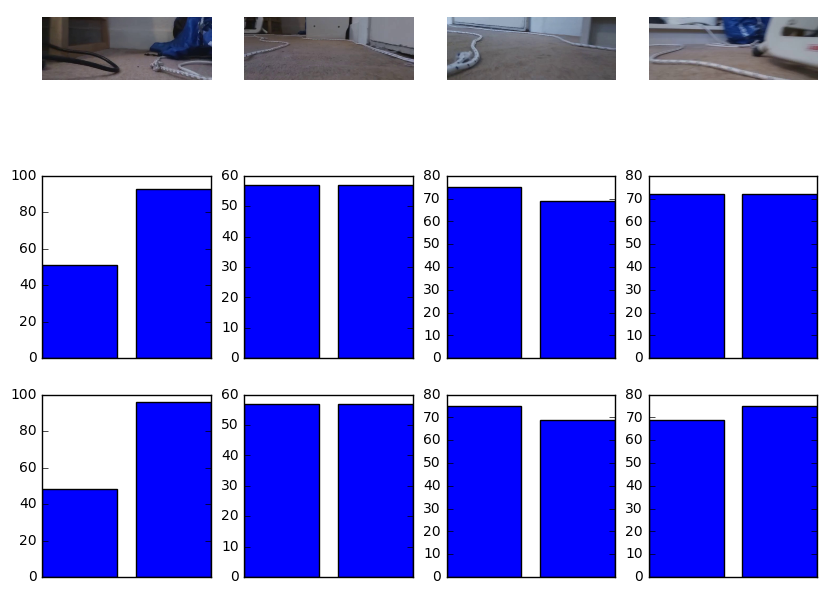

In [27]:
n_imgs = 4
imfiles = [np.random.choice(speeds.keys()) for _ in range(n_imgs)]
fig = plt.figure(figsize=(10, 8))
for i, imfile in enumerate(imfiles):
    impath, lt_speed, rt_speed, lt_speed_aft, rt_speed_aft = speeds[imfile]
    img = imresize(imread(impath, mode="RGB"), (150, 400))
    print(img.shape)
    ax = fig.add_subplot(3, n_imgs, i+1)
    ax.set_axis_off()
    ax.imshow(img)
    
    ax = fig.add_subplot(3, n_imgs, i+1+n_imgs)
    ax.bar([0, 1], [lt_speed, rt_speed])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    
    ax = fig.add_subplot(3, n_imgs, i+1+2*n_imgs)
    ax.bar([0, 1], [lt_speed_aft, rt_speed_aft])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    
fig.show()
    

In [28]:
imgs = []
b_speeds = []
y = []

for info in speeds.values():
    im = imread(info[0], mode="RGB")
    im = imresize(im, (150, 400))
    im = np.rollaxis(im, 2, 0) # so that shape is (3, 150, 400)
    imgs.append(im)
    b_speeds.append(info[1:3])
    y.append(info[3:5])
    

In [29]:
imgs, b_speeds, y = np.array(imgs), np.array(b_speeds), np.array(y)

In [30]:
print imgs.shape, b_speeds.shape, y.shape

(7850, 3, 150, 400) (7850, 2) (7850, 2)


In [31]:
from keras.layers import Input, Convolution2D, Dropout, Merge, Activation, MaxPooling2D, Flatten, Dense, merge
from keras.models import Model

input_img = Input(shape=(3, 150, 400), name="img_in")

x = Convolution2D(8, 3, 3)(input_img)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

input_speeds= Input(shape=(2,), name="speed_in")
speed_branch = Activation("linear")(input_speeds)

merged = merge([x, speed_branch], mode="concat")

x = Dense(256)(merged)
x = Activation("linear")(x)
x = Dropout(0.2)(x)

speeds_out = Dense(2, name="speed_out")(x)

model = Model(input=[input_img, input_speeds], output=[speeds_out])
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_2" was not an Input tensor, it was generated by layer activation_21.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: speed_in
  str(x.name))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 3, 150, 400)   0                                            
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 8, 148, 398)   224         img_in[0][0]                     
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 8, 148, 398)   0           convolution2d_16[0][0]           
____________________________________________________________________________________________________
maxpooling2d_14 (MaxPooling2D)   (None, 8, 74, 199)    0           activation_18[0][0]              
___________________________________________________________________________________________

In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = os.path.expanduser("~/aveta-model.hdf5")
save_best = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=0, mode="auto")
cbs = [save_best, early_stop]

In [34]:
model.fit([imgs, b_speeds], y, nb_epoch=100, validation_split=0.1, callbacks=cbs, batch_size=320)

Train on 7065 samples, validate on 785 samples
Epoch 1/100
7065/7065 [==============================] - 13s - loss: 660.1719 - val_loss: 599.0913
Epoch 2/100
7065/7065 [==============================] - 13s - loss: 539.4276 - val_loss: 485.6347
Epoch 3/100
7065/7065 [==============================] - 13s - loss: 418.9805 - val_loss: 426.6419
Epoch 4/100
7065/7065 [==============================] - 13s - loss: 366.9203 - val_loss: 381.6476
Epoch 5/100
7065/7065 [==============================] - 13s - loss: 331.4544 - val_loss: 367.0774
Epoch 6/100
7065/7065 [==============================] - 13s - loss: 308.8537 - val_loss: 320.1544
Epoch 7/100
7065/7065 [==============================] - 13s - loss: 287.1549 - val_loss: 331.9124
Epoch 8/100
7065/7065 [==============================] - 13s - loss: 273.2708 - val_loss: 298.5480
Epoch 9/100
7065/7065 [==============================] - 13s - loss: 258.7578 - val_loss: 287.7725
Epoch 10/100
7065/7065 [==============================] - 13s 

In [61]:
import pandas as pd
import random
X = [imgs, b_speeds]
randindices = random.sample(range(len(imgs)), 500)
batch_imgs = []
batch_speeds = []
batch_out = []
for i in randindices:
    batch_imgs.append(imgs[i])
    batch_speeds.append(b_speeds[i])
    batch_out.append(y[i])
batch_out = np.array(batch_out)
pred = model.predict([np.array(batch_imgs), np.array(batch_speeds)])


In [65]:
def plot_one_on_one(actual, predicted):
    fig = plt.figure()
    sides = ["left", "right"]
    for i in range(2):
        ax = fig.add_subplot(2, 1, i+1)
        ax.plot(actual[:,i], label="actual {}".format(sides[i]))
        ax.hold(True)
        ax.plot(predicted[:,i], label="predicted {}".format(sides[i]))
        ax.legend(bbox_to_anchor=(1.1, 1.2))
    fig.show()

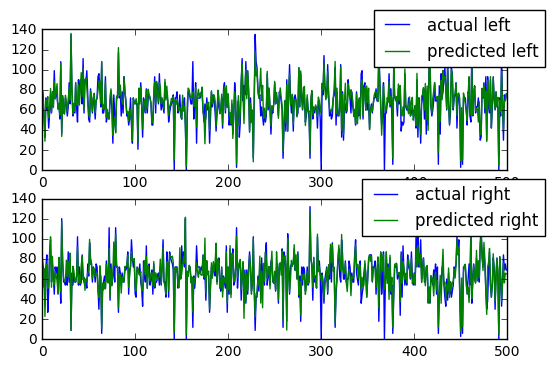

In [67]:
plot_one_on_one(batch_out, pred)

In [ ]:
start, end = 1000, 1400
X = [imgs[start:end], b_speeds[start:end]]
actual_output = y[start:end]
plot_one_on_one(model.predict(X))
